In [11]:
import pandas as pd
import yfinance as yf
from bcb import sgs, currency
import datetime
import time

# --- 1. CONFIGURAÇÕES GERAIS ---
# Mantenha todas as suas variáveis de entrada em um só lugar.
START_DATE = '2023-01-01'
END_DATE = datetime.date.today()

TICKERS = ['^BVSP', '^GSPC', 'GLD', 'SPHD', 'QQQ']
ASSETS_IN_USD = ['^GSPC', 'GLD', 'SPHD', 'QQQ']
NOMES_ATIVOS = {
    '^BVSP': 'Ibovespa',
    '^GSPC': 'S&P 500',
    'GLD': 'Ouro',
    'SPHD': 'ETF SPHD',
    'QQQ': 'ETF QQQ',
    'CDI': 'CDI'
}


# --- 2. FUNÇÕES DE COLETA DE DADOS ---

def fetch_bcb_data(series_code: int, series_name: str, start_date: str, end_date: datetime.date) -> pd.DataFrame:
    """Busca uma série temporal do Banco Central do Brasil (BCB)."""
    print(f"Buscando dados para {series_name}...")
    try:
        df = sgs.get({series_name: series_code}, start=start_date, end=end_date)
        df.index = df.index.tz_localize(None)
        print(f"Sucesso ao buscar {series_name}.")
        return df
    except Exception as e:
        print(f"ERRO: Falha ao buscar dados para {series_name}. {e}")
        return pd.DataFrame()

def fetch_yfinance_data(tickers: list, start_date: str, end_date: datetime.date) -> pd.DataFrame:
    """Busca os preços de fechamento de múltiplos ativos no Yahoo Finance."""
    print("Iniciando download dos ativos via yfinance...")
    try:
        # Baixa todos os tickers de uma vez para maior eficiência
        df = yf.download(tickers, start=start_date, end=end_date, progress=False)['Close']
        print("Download concluído.")
        if df.empty:
            raise ValueError("O download do yfinance não retornou dados.")
        # Remove tickers que falharam (colunas com todos os valores nulos)
        df.dropna(axis=1, how='all', inplace=True)
        return df
    except Exception as e:
        print(f"ERRO: Falha ao baixar dados do yfinance. {e}")
        return pd.DataFrame()


# --- 3. FUNÇÃO DE PROCESSAMENTO E CONSOLIDAÇÃO ---

def process_data(precos_ativos: pd.DataFrame, cotacoes_dolar: pd.DataFrame, rendimento_cdi: pd.DataFrame) -> pd.DataFrame:
    """Consolida, converte para BRL e calcula os retornos diários."""
    print("Iniciando processamento dos dados...")
    
    # Preenche valores ausentes (feriados, etc.)
    precos_ativos.ffill(inplace=True)
    cotacoes_dolar.ffill(inplace=True)

    # Junta os preços dos ativos com a cotação do dólar
    dados_para_converter = precos_ativos.join(cotacoes_dolar)
    dados_para_converter['USD'].ffill(inplace=True)

    # Converte os ativos de USD para BRL de forma vetorizada (mais rápido)
    precos_brl = precos_ativos.copy()
    for ticker in ASSETS_IN_USD:
        if ticker in precos_brl.columns:
            precos_brl[ticker] = precos_brl[ticker] * dados_para_converter['USD']
    
    # Renomeia colunas para nomes amigáveis
    precos_brl.rename(columns=NOMES_ATIVOS, inplace=True)
    rendimento_cdi.rename(columns=NOMES_ATIVOS, inplace=True)

    # Calcula os retornos diários de todos os ativos (já em REAL)
    retornos_variaveis_brl = precos_brl.pct_change()

    # Junta os retornos com o CDI e remove linhas com dados faltantes
    dados_completos = retornos_variaveis_brl.join(rendimento_cdi, how='inner')
    dados_completos.dropna(inplace=True)
    
    print("Processamento concluído.")
    return dados_completos


# --- 4. EXECUÇÃO PRINCIPAL ---

if __name__ == "__main__":
    # Coleta de Dados
    cotacoes_do_dolar = fetch_bcb_data(series_code=1, series_name='USD', start_date=START_DATE, end_date=END_DATE)
    rendimento_cdi = fetch_bcb_data(series_code=12, series_name='CDI', start_date=START_DATE, end_date=END_DATE)
    
    # O CDI vem como taxa, precisa ser dividido por 100
    if not rendimento_cdi.empty:
        rendimento_cdi = rendimento_cdi / 100

    precos_dos_ativos = fetch_yfinance_data(tickers=TICKERS, start_date=START_DATE, end_date=END_DATE)

    # Verificação de Dados Essenciais
    if precos_dos_ativos.empty or cotacoes_do_dolar.empty or rendimento_cdi.empty:
        raise ValueError("ERRO: Falha na coleta de um ou mais dados essenciais. A análise não pode continuar.")
    
    # Processamento e Consolidação
    dados_finais = process_data(
        precos_ativos=precos_dos_ativos,
        cotacoes_dolar=cotacoes_do_dolar,
        rendimento_cdi=rendimento_cdi
    )

    print("\n--- Amostra dos Dados Finais (Retornos Diários em BRL) ---")
    print(dados_finais.head())
    print("\n--- Resumo Estatístico ---")
    print(dados_finais.describe())

Buscando dados para USD...
Sucesso ao buscar USD.
Buscando dados para CDI...
Sucesso ao buscar CDI.
Iniciando download dos ativos via yfinance...


/tmp/ipykernel_18822/3846582253.py:43: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers, start=start_date, end=end_date, progress=False)['Close']


Download concluído.
Iniciando processamento dos dados...
Processamento concluído.

--- Amostra dos Dados Finais (Retornos Diários em BRL) ---
                Ouro   ETF QQQ  ETF SPHD  Ibovespa   S&P 500       CDI
Date                                                                  
2023-01-04  0.022556  0.017847  0.027526  0.011213  0.020658  0.000508
2023-01-05 -0.020303 -0.023481 -0.018621  0.020734 -0.019504  0.000508
2023-01-06 -0.003373  0.005328  0.001371  0.012258  0.000671  0.000508
2023-01-09  0.004369  0.008606 -0.002981  0.003593  0.001350  0.000508
2023-01-10 -0.007163 -0.002426 -0.007719  0.015427 -0.003896  0.000508

--- Resumo Estatístico ---
             Ouro     ETF QQQ    ETF SPHD    Ibovespa     S&P 500         CDI
count  690.000000  690.000000  690.000000  690.000000  690.000000  690.000000
mean     0.001078    0.001456    0.000409    0.000514    0.000993    0.000470
std      0.011200    0.013411    0.009866    0.009468    0.010811    0.000055
min     -0.036583   -

/tmp/ipykernel_18822/3846582253.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dados_para_converter['USD'].ffill(inplace=True)


Buscando dados para USD...
Sucesso ao buscar USD.
Buscando dados para CDI...
Sucesso ao buscar CDI.
Iniciando download dos ativos via yfinance...


/tmp/ipykernel_18822/1288597704.py:44: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers, start=start_date, end=end_date, progress=False)['Close']


Download concluído.
Iniciando processamento dos dados...
Processamento concluído.

--- Amostra dos Dados Finais (Retornos Diários em BRL) ---
                Ouro   ETF QQQ  ETF SPHD  Ibovespa   S&P 500       CDI
Date                                                                  
2024-01-03 -0.002336 -0.004594  0.000216  0.001032 -0.002014  0.000437
2024-01-04  0.000516 -0.005632 -0.001654 -0.012105 -0.003914  0.000437
2024-01-05 -0.005718 -0.004696 -0.000069  0.006073 -0.004060  0.000437
2024-01-08 -0.008811  0.019645  0.004799  0.003060  0.013098  0.000437
2024-01-09  0.002101  0.003760 -0.004002 -0.007400  0.000300  0.000437

Gerando o gráfico de retorno acumulado...


/tmp/ipykernel_18822/1288597704.py:63: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dados_para_converter['USD'].ffill(inplace=True)


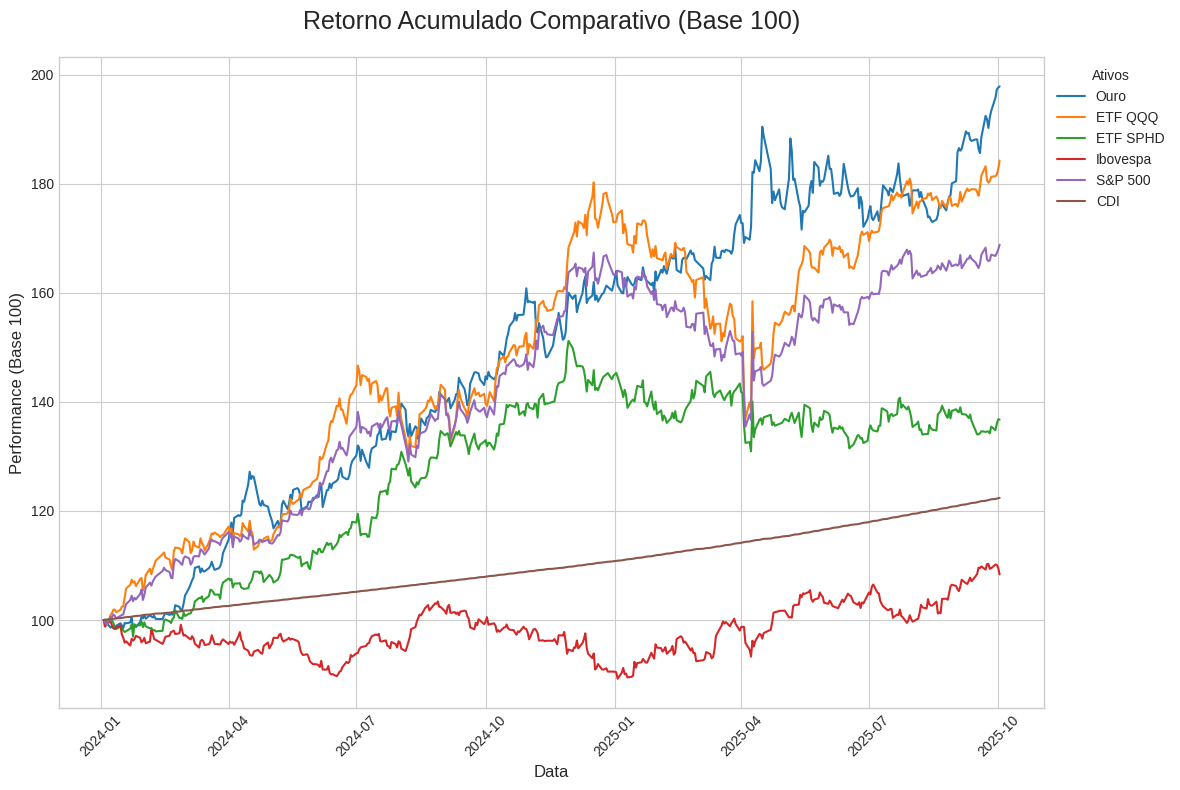

In [14]:
import pandas as pd
import yfinance as yf
from bcb import sgs, currency
import datetime
import time
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# --- 1. CONFIGURAÇÕES GERAIS ---
# Mantenha todas as suas variáveis de entrada em um só lugar.
START_DATE = '2024-01-01'
END_DATE = datetime.date.today()

TICKERS = ['^BVSP', '^GSPC', 'GLD', 'SPHD', 'QQQ']
ASSETS_IN_USD = ['^GSPC', 'GLD', 'SPHD', 'QQQ']
NOMES_ATIVOS = {
    '^BVSP': 'Ibovespa',
    '^GSPC': 'S&P 500',
    'GLD': 'Ouro',
    'SPHD': 'ETF SPHD',
    'QQQ': 'ETF QQQ',
    'CDI': 'CDI'
}


# --- 2. FUNÇÕES DE COLETA DE DADOS ---

def fetch_bcb_data(series_code: int, series_name: str, start_date: str, end_date: datetime.date) -> pd.DataFrame:
    """Busca uma série temporal do Banco Central do Brasil (BCB)."""
    print(f"Buscando dados para {series_name}...")
    try:
        df = sgs.get({series_name: series_code}, start=start_date, end=end_date)
        df.index = df.index.tz_localize(None)
        print(f"Sucesso ao buscar {series_name}.")
        return df
    except Exception as e:
        print(f"ERRO: Falha ao buscar dados para {series_name}. {e}")
        return pd.DataFrame()

def fetch_yfinance_data(tickers: list, start_date: str, end_date: datetime.date) -> pd.DataFrame:
    """Busca os preços de fechamento de múltiplos ativos no Yahoo Finance."""
    print("Iniciando download dos ativos via yfinance...")
    try:
        df = yf.download(tickers, start=start_date, end=end_date, progress=False)['Close']
        print("Download concluído.")
        if df.empty:
            raise ValueError("O download do yfinance não retornou dados.")
        df.dropna(axis=1, how='all', inplace=True)
        return df
    except Exception as e:
        print(f"ERRO: Falha ao baixar dados do yfinance. {e}")
        return pd.DataFrame()


# --- 3. FUNÇÃO DE PROCESSAMENTO E CONSOLIDAÇÃO ---

def process_data(precos_ativos: pd.DataFrame, cotacoes_dolar: pd.DataFrame, rendimento_cdi: pd.DataFrame) -> pd.DataFrame:
    """Consolida, converte para BRL e calcula os retornos diários."""
    print("Iniciando processamento dos dados...")
    precos_ativos.ffill(inplace=True)
    cotacoes_dolar.ffill(inplace=True)
    dados_para_converter = precos_ativos.join(cotacoes_dolar)
    dados_para_converter['USD'].ffill(inplace=True)
    precos_brl = precos_ativos.copy()
    for ticker in ASSETS_IN_USD:
        if ticker in precos_brl.columns:
            precos_brl[ticker] = precos_brl[ticker] * dados_para_converter['USD']
    precos_brl.rename(columns=NOMES_ATIVOS, inplace=True)
    rendimento_cdi.rename(columns=NOMES_ATIVOS, inplace=True)
    retornos_variaveis_brl = precos_brl.pct_change()
    dados_completos = retornos_variaveis_brl.join(rendimento_cdi, how='inner')
    dados_completos.dropna(inplace=True)
    print("Processamento concluído.")
    return dados_completos


# --- 4. FUNÇÃO DE VISUALIZAÇÃO DE DADOS ---

def plot_cumulative_returns(daily_returns_df: pd.DataFrame):
    """Calcula e plota o gráfico de retornos acumulados normalizados (Base 100)."""
    print("\nGerando o gráfico de retorno acumulado...")
    
    # Calcula o retorno acumulado e normaliza para Base 100
    retorno_acumulado = (1 + daily_returns_df).cumprod()
    retorno_acumulado_normalizado = (retorno_acumulado / retorno_acumulado.iloc[0]) * 100

    # Configurações do Gráfico
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(14, 8))

    # Plota uma linha para cada ativo
    for ativo in retorno_acumulado_normalizado.columns:
        ax.plot(
            retorno_acumulado_normalizado.index,
            retorno_acumulado_normalizado[ativo],
            label=ativo
        )

    # Customização dos Títulos, Eixos e Legenda
    ax.set_title('Retorno Acumulado Comparativo (Base 100)', fontsize=18, pad=20)
    ax.set_xlabel('Data', fontsize=12)
    ax.set_ylabel('Performance (Base 100)', fontsize=12)

    ax.legend(
        title='Ativos',
        loc='upper left',
        bbox_to_anchor=(1, 1) # Posiciona a legenda fora da área do gráfico
    )

    # Formatação dos Ticks
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f'{int(y)}'))
    ax.tick_params(axis='x', rotation=45)

    # Ajusta o layout para garantir que a legenda não seja cortada
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    
    # Exibe o gráfico
    plt.show()


# --- 5. EXECUÇÃO PRINCIPAL ---

if __name__ == "__main__":
    # Coleta de Dados
    cotacoes_do_dolar = fetch_bcb_data(1, 'USD', START_DATE, END_DATE)
    rendimento_cdi = fetch_bcb_data(12, 'CDI', START_DATE, END_DATE)
    
    if not rendimento_cdi.empty:
        rendimento_cdi = rendimento_cdi / 100

    precos_dos_ativos = fetch_yfinance_data(TICKERS, START_DATE, END_DATE)

    # Verificação de Dados Essenciais
    if precos_dos_ativos.empty or cotacoes_do_dolar.empty or rendimento_cdi.empty:
        raise ValueError("ERRO: Falha na coleta de um ou mais dados essenciais. A análise não pode continuar.")
    
    # Processamento e Consolidação
    dados_finais = process_data(
        precos_ativos=precos_dos_ativos,
        cotacoes_dolar=cotacoes_do_dolar,
        rendimento_cdi=rendimento_cdi
    )

    print("\n--- Amostra dos Dados Finais (Retornos Diários em BRL) ---")
    print(dados_finais.head())

    # Geração do Gráfico
    plot_cumulative_returns(daily_returns_df=dados_finais)